# Implementation of DNN from scratch using OOP and numpy

In this notebook, I implement DNN using numpy only and declare these layers in terms of classes, writing forward and backward functions inside these classes. This is much more compact than writing the forward and backward equations in separate functions and takes much less lines to write.

This method of coding is learned from "The Independent Code" Channel in youtube from their playlist of writing neural networks from scratch: https://www.youtube.com/@independentcode

## Base Layer

Two attributes. Declared for convenience so other layers don't have to declare them:

* `self.forward()` - return layer output
* `self.backward()` - update parameters of the layer and return input gradient. We can pass an optimizer here as inputs but, for simplicity, we will pass only the learning rate here to update via Gradient Descent



In [2]:
import numpy as np

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass


In [3]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1 - np.tanh(x) ** 2
        super().__init__(tanh, tanh_prime)

class ReLU(Activation):
    def __init__(self):
        relu = lambda x: np.maximum(x, 0)
        relu_prime = lambda x: (x > 0).astype("float32")
        super().__init__(relu, relu_prime)

In [5]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [15]:
# Solving the XOR problem, as a quick and dirty way of checking if the NN truly works

X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]
#
epochs = 10000
learning_rate = 0.1
# train
for e in range(epochs):
    error = 0
    for x, y in zip(X, Y):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)

        # error (calculating the loss)
        error += mse(y, output)

        # backward
        grad = mse_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

    error /= len(X)
    if (e+1)%1000 == 0:
        print(f"{e + 1}/{epochs}, error = {error}")

1000/10000, error = 0.0002627072132023019
2000/10000, error = 0.00011730608439815131
3000/10000, error = 7.471335055320411e-05
4000/10000, error = 5.456740581261125e-05
5000/10000, error = 6.31728801774997e-05
6000/10000, error = 0.00015275016729353078
7000/10000, error = 5.186981209420963e-05
8000/10000, error = 9.712707083932962e-05
9000/10000, error = 0.0001481495483680332
10000/10000, error = 6.985278133414468e-05


In [19]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose and (e+1)%1000==0:
            print(f"{e + 1}/{epochs}, error={error}")

1000/10000, error=0.0007812087431654773
2000/10000, error=0.000138517709395322
3000/10000, error=7.40007840569615e-05
4000/10000, error=6.190300531899634e-05
5000/10000, error=3.700328960453231e-05
6000/10000, error=2.9475297293195407e-05
7000/10000, error=2.4470247759736658e-05
8000/10000, error=2.4707193595594202e-05
9000/10000, error=2.551697045010897e-05
10000/10000, error=1.6083612775859854e-05


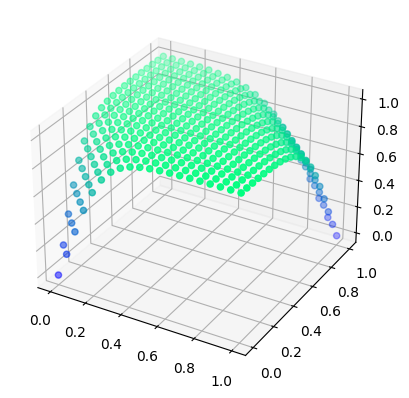

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

# train
train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)


# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()